## P39 to 41 Search Pretrained

- Ok ok ok ok ok
- Time to nail down 2-4 interestin directions in parameter space
- I want to put 2 together to make a cool/interesting global view
- Then I'll need to fake gradient descent on that, that should be interesting. 

In [1]:
# ! pip install transformers matplotlib tqdm huggingface_hub

In [2]:
# from huggingface_hub import login
# login()

In [3]:
import torch
from transformers import pipeline
from torch.nn import functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import copy
from collections import OrderedDict

from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config
from transformers import LlamaForCausalLM, PreTrainedTokenizerFast, LlamaConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

device='cuda'

In [4]:
model_id = "meta-llama/Llama-3.2-1B"
# model_id = "openai-community/gpt2"
# model_id = "google/gemma-3-1b-pt"
# model_id = "gpt2"

In [5]:
# #Only needed for llama random initialization
# config_dict = {
#   "_attn_implementation_autoset": True,
#   "architectures": [
#     "LlamaForCausalLM"
#   ],
#   "attention_bias": False,
#   "attention_dropout": 0.0,
#   "bos_token_id": 128000,
#   "eos_token_id": 128001,
#   "head_dim": 64,
#   "hidden_act": "silu",
#   "hidden_size": 2048,
#   "initializer_range": 0.02,
#   "intermediate_size": 8192,
#   "max_position_embeddings": 131072,
#   "mlp_bias": False,
#   "model_type": "llama",
#   "num_attention_heads": 32,
#   "num_hidden_layers": 16,
#   "num_key_value_heads": 8,
#   "pretraining_tp": 1,
#   "rms_norm_eps": 1e-05,
#   "rope_scaling": {
#     "factor": 32.0,
#     "high_freq_factor": 4.0,
#     "low_freq_factor": 1.0,
#     "original_max_position_embeddings": 8192,
#     "rope_type": "llama3"
#   },
#   "rope_theta": 500000.0,
#   "tie_word_embeddings": True,
#   "torch_dtype": "float32",
#   "transformers_version": "4.50.3",
#   "use_cache": True,
#   "vocab_size": 128256
# }

In [6]:
# Random init
# model_config = GPT2Config() #Full sized model
# model = GPT2LMHeadModel(model_config).to(device) #Ok i should see what happens with full and pretrained model. 
# tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# # Llama with random initialization
# model_config  = LlamaConfig.from_dict(config_dict)
# model = LlamaForCausalLM(model_config).to(device) 
# tokenizer = AutoTokenizer.from_pretrained(model_id)

#Pretrained
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [ ]:
model.eval()

In [7]:
text = "The capital of France is Paris"
inputs = tokenizer(text, return_tensors="pt").to(device)
input_ids = inputs["input_ids"]

In [8]:
with torch.no_grad():
    outputs = model(input_ids, labels=input_ids)

my_probs=F.softmax(outputs.logits, dim=-1)
y_one_hot=F.one_hot(input_ids, num_classes=model.config.vocab_size)
correct_next_token_probs = (my_probs[:,:-1]*y_one_hot[:,1:]).sum(-1) #I'm sure there's waaay more efficient ways to do this
my_loss=-torch.log(correct_next_token_probs).mean()
print(my_loss.item(), outputs.loss.item())

3.3751838207244873 3.3751838207244873


- To Do -> try with just loss on Paris token

In [9]:
with torch.no_grad():
    outputs = model(input_ids, labels=input_ids)

my_probs=F.softmax(outputs.logits, dim=-1)
y_one_hot=F.one_hot(input_ids, num_classes=model.config.vocab_size)
correct_next_token_probs = (my_probs[:,:-1]*y_one_hot[:,1:]).sum(-1) #I'm sure there's waaay more efficient ways to do this
my_loss=-torch.log(correct_next_token_probs).mean()

paris_only_loss=-np.log(my_probs[0, 5, 12366].item())
print(my_loss.item(), outputs.loss.item(), paris_only_loss)

3.3751838207244873 3.3751838207244873 0.9376916737061879


In [10]:
def get_random_directions(params, seed=None):
    """
    Generate random direction vectors for each parameter tensor.
    
    Args:
        params: List of (name, parameter) tuples from model.named_parameters()
        seed: Random seed for reproducibility
        
    Returns:
        direction: OrderedDict mapping parameter names to random direction tensors
    """
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)
    
    direction = OrderedDict()
    for name, param in params:
        if param.requires_grad:
            direction[name] = torch.randn_like(param.data)
    
    return direction

In [11]:
def normalize_direction(direction, params):
    """
    Normalize the direction tensors to match the norm of each parameter tensor.
    
    Args:
        direction: OrderedDict mapping parameter names to direction tensors
        params: List of (name, parameter) tuples from model.named_parameters()
        
    Returns:
        normalized_direction: OrderedDict with normalized direction tensors
    """
    param_dict = OrderedDict(params)
    normalized_direction = OrderedDict()
    
    for name, dir_tensor in direction.items():
        param_norm = torch.norm(param_dict[name].data)
        dir_norm = torch.norm(dir_tensor)
        
        # Avoid division by zero
        if dir_norm > 0:
            normalized_direction[name] = dir_tensor * (param_norm / dir_norm)
        else:
            normalized_direction[name] = dir_tensor
    
    return normalized_direction

In [12]:
save_dir='/home/stephen/backparopagation/apr_23_1'

0 100


100%|█████████████████████████████████████████████████████████| 96/96 [05:08<00:00,  3.21s/it]


1 101


100%|█████████████████████████████████████████████████████████| 96/96 [05:14<00:00,  3.27s/it]


2 102


100%|█████████████████████████████████████████████████████████| 96/96 [05:19<00:00,  3.33s/it]


3 103


100%|█████████████████████████████████████████████████████████| 96/96 [05:22<00:00,  3.36s/it]


4 104


100%|█████████████████████████████████████████████████████████| 96/96 [05:25<00:00,  3.39s/it]


5 105


100%|█████████████████████████████████████████████████████████| 96/96 [05:19<00:00,  3.33s/it]


6 106


100%|█████████████████████████████████████████████████████████| 96/96 [05:24<00:00,  3.38s/it]


7 107


100%|█████████████████████████████████████████████████████████| 96/96 [05:25<00:00,  3.39s/it]


8 108


100%|█████████████████████████████████████████████████████████| 96/96 [05:24<00:00,  3.38s/it]


9 109


100%|█████████████████████████████████████████████████████████| 96/96 [05:23<00:00,  3.37s/it]
/tmp/ipykernel_136955/1573134231.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10, 8))


10 110


100%|█████████████████████████████████████████████████████████| 96/96 [05:20<00:00,  3.34s/it]


11 111


100%|█████████████████████████████████████████████████████████| 96/96 [05:24<00:00,  3.38s/it]


12 112


100%|█████████████████████████████████████████████████████████| 96/96 [05:25<00:00,  3.39s/it]


13 113


100%|█████████████████████████████████████████████████████████| 96/96 [05:22<00:00,  3.36s/it]


14 114


100%|█████████████████████████████████████████████████████████| 96/96 [05:20<00:00,  3.34s/it]


15 115


100%|█████████████████████████████████████████████████████████| 96/96 [05:19<00:00,  3.32s/it]


16 116


100%|█████████████████████████████████████████████████████████| 96/96 [05:24<00:00,  3.38s/it]


17 117


100%|█████████████████████████████████████████████████████████| 96/96 [05:22<00:00,  3.36s/it]


18 118


100%|█████████████████████████████████████████████████████████| 96/96 [05:21<00:00,  3.34s/it]


19 119


100%|█████████████████████████████████████████████████████████| 96/96 [05:27<00:00,  3.41s/it]


20 120


100%|█████████████████████████████████████████████████████████| 96/96 [05:25<00:00,  3.39s/it]


21 121


100%|█████████████████████████████████████████████████████████| 96/96 [05:21<00:00,  3.35s/it]


22 122


100%|█████████████████████████████████████████████████████████| 96/96 [05:26<00:00,  3.40s/it]


23 123


100%|█████████████████████████████████████████████████████████| 96/96 [05:26<00:00,  3.41s/it]


24 124


100%|█████████████████████████████████████████████████████████| 96/96 [05:26<00:00,  3.40s/it]


25 125


100%|█████████████████████████████████████████████████████████| 96/96 [05:25<00:00,  3.39s/it]


26 126


100%|█████████████████████████████████████████████████████████| 96/96 [05:21<00:00,  3.35s/it]


27 127


100%|█████████████████████████████████████████████████████████| 96/96 [05:25<00:00,  3.40s/it]


28 128


100%|█████████████████████████████████████████████████████████| 96/96 [05:25<00:00,  3.39s/it]


29 129


100%|█████████████████████████████████████████████████████████| 96/96 [05:25<00:00,  3.39s/it]


30 130


100%|█████████████████████████████████████████████████████████| 96/96 [05:23<00:00,  3.37s/it]


31 131


100%|█████████████████████████████████████████████████████████| 96/96 [05:25<00:00,  3.39s/it]


<Figure size 640x480 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

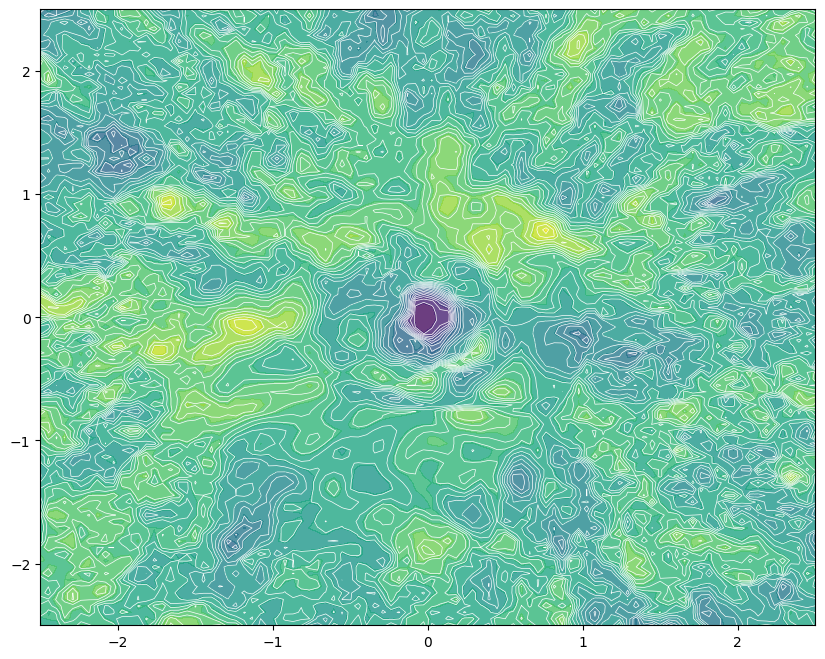

In [13]:
prefix='pretrained_'
filtered_params = [(name, p) for name, p in model.named_parameters() if p.requires_grad]
# layers_name='all'

layers_name='first_8'
filtered_params = filtered_params[1:73] #First 8 layers - I like this - facorite so far

# layers_name='last_8'
# filtered_params = filtered_params[73:] #Last 8 layers - some nice structue, but yeah more parabolic than I would like

num_points=96
num_samples=32

random_seeds=[[i, i+100] for i in range(num_samples)]

for random_seed_1, random_seed_2 in random_seeds:
    print(random_seed_1, random_seed_2)
    
    # Generate and normalize random directions
    direction1 = get_random_directions(filtered_params, seed=random_seed_1)
    direction2 = get_random_directions(filtered_params, seed=random_seed_2)
    
    direction1 = normalize_direction(direction1, filtered_params)
    direction2 = normalize_direction(direction2, filtered_params)
    
    original_params = OrderedDict()
    for name, param in filtered_params:
        original_params[name] = param.data.clone()
    
    alphas=np.linspace(-2.5, 2.5, num_points)
    betas=np.linspace(-2.5, 2.5, num_points)
    losses=[]
    model.eval()
    with torch.no_grad():
        for i, alpha in enumerate(tqdm(alphas)):
            losses.append([])
            for j, beta in enumerate(betas):
                for name, param in model.named_parameters():
                    if name in direction1:
                        param.data = original_params[name] + alpha * direction1[name] + beta*direction2[name]
                
                outputs = model(input_ids, labels=input_ids)
                my_probs=F.softmax(outputs.logits, dim=-1)
                paris_only_loss=-np.log(my_probs[0, 5, 12366].item())
                losses[-1].append(paris_only_loss)
        
        for name, param in model.named_parameters(): # Restore original parameters
            if name in original_params: 
                param.data.copy_(original_params[name])
    
    losses=np.array(losses)
    
    plt.clf()
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    surface = ax.plot_surface(alphas, betas, losses, cmap='viridis', edgecolor='none', alpha=0.8)
    plt.savefig(save_dir +'/'+prefix+str(random_seed_1)+'_'+str(random_seed_2)+'_'+layers_name+'_3d.png')
    
    plt.clf()
    fig, ax = plt.subplots(figsize=(10, 8))
    contourf = ax.contourf(alphas, betas, losses, 20, cmap='viridis', alpha=0.8)
    contour = ax.contour(alphas, betas, losses, 30, colors='white', linewidths=0.5)
    plt.savefig(save_dir +'/'+prefix+str(random_seed_1)+'_'+str(random_seed_2)+'_'+layers_name+'_2d.png')

0 100


100%|█████████████████████████████████████████████████████████| 96/96 [05:27<00:00,  3.41s/it]


1 101


100%|█████████████████████████████████████████████████████████| 96/96 [05:25<00:00,  3.40s/it]


2 102


100%|█████████████████████████████████████████████████████████| 96/96 [05:27<00:00,  3.41s/it]


3 103


100%|█████████████████████████████████████████████████████████| 96/96 [05:27<00:00,  3.41s/it]


4 104


100%|█████████████████████████████████████████████████████████| 96/96 [05:26<00:00,  3.40s/it]


5 105


100%|█████████████████████████████████████████████████████████| 96/96 [05:26<00:00,  3.41s/it]


6 106


100%|█████████████████████████████████████████████████████████| 96/96 [05:28<00:00,  3.42s/it]


7 107


100%|█████████████████████████████████████████████████████████| 96/96 [05:25<00:00,  3.39s/it]


8 108


100%|█████████████████████████████████████████████████████████| 96/96 [05:25<00:00,  3.39s/it]


9 109


100%|█████████████████████████████████████████████████████████| 96/96 [05:23<00:00,  3.37s/it]
/tmp/ipykernel_136955/1180487549.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10, 8))


10 110


100%|█████████████████████████████████████████████████████████| 96/96 [05:26<00:00,  3.40s/it]


11 111


100%|█████████████████████████████████████████████████████████| 96/96 [05:27<00:00,  3.41s/it]


12 112


100%|█████████████████████████████████████████████████████████| 96/96 [05:25<00:00,  3.39s/it]


13 113


100%|█████████████████████████████████████████████████████████| 96/96 [05:24<00:00,  3.38s/it]


14 114


100%|█████████████████████████████████████████████████████████| 96/96 [05:23<00:00,  3.37s/it]


15 115


100%|█████████████████████████████████████████████████████████| 96/96 [05:27<00:00,  3.41s/it]


16 116


100%|█████████████████████████████████████████████████████████| 96/96 [05:23<00:00,  3.37s/it]


17 117


100%|█████████████████████████████████████████████████████████| 96/96 [05:26<00:00,  3.40s/it]


18 118


100%|█████████████████████████████████████████████████████████| 96/96 [05:27<00:00,  3.41s/it]


19 119


100%|█████████████████████████████████████████████████████████| 96/96 [05:26<00:00,  3.40s/it]


20 120


100%|█████████████████████████████████████████████████████████| 96/96 [05:27<00:00,  3.41s/it]


21 121


100%|█████████████████████████████████████████████████████████| 96/96 [05:26<00:00,  3.41s/it]


22 122


100%|█████████████████████████████████████████████████████████| 96/96 [05:25<00:00,  3.39s/it]


23 123


100%|█████████████████████████████████████████████████████████| 96/96 [05:26<00:00,  3.40s/it]


24 124


100%|█████████████████████████████████████████████████████████| 96/96 [05:26<00:00,  3.40s/it]


25 125


100%|█████████████████████████████████████████████████████████| 96/96 [05:26<00:00,  3.40s/it]


26 126


100%|█████████████████████████████████████████████████████████| 96/96 [05:28<00:00,  3.42s/it]


27 127


100%|█████████████████████████████████████████████████████████| 96/96 [05:32<00:00,  3.46s/it]


28 128


100%|█████████████████████████████████████████████████████████| 96/96 [05:26<00:00,  3.40s/it]


29 129


100%|█████████████████████████████████████████████████████████| 96/96 [05:27<00:00,  3.41s/it]


30 130


100%|█████████████████████████████████████████████████████████| 96/96 [05:27<00:00,  3.41s/it]


31 131


100%|█████████████████████████████████████████████████████████| 96/96 [05:27<00:00,  3.41s/it]


<Figure size 640x480 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

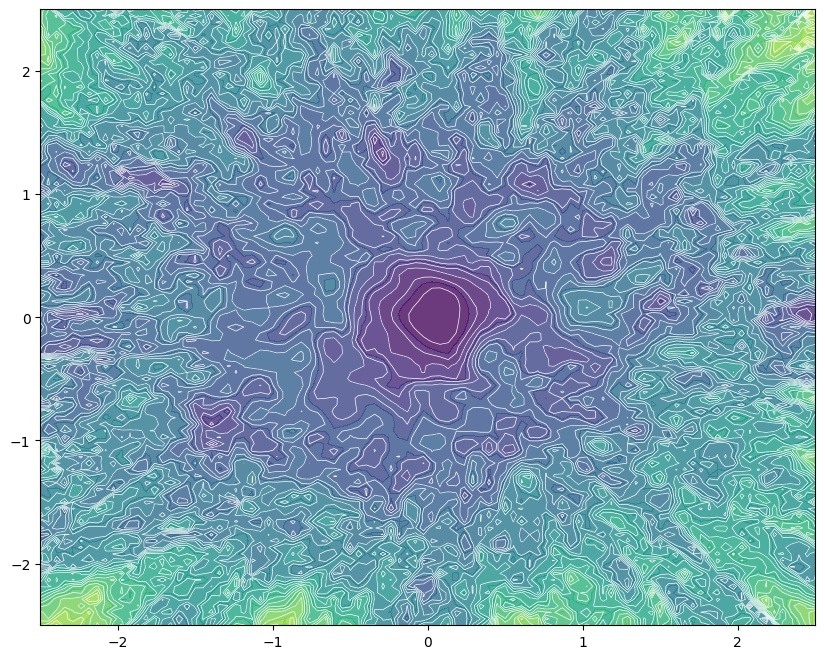

In [14]:
filtered_params = [(name, p) for name, p in model.named_parameters() if p.requires_grad]
# layers_name='all'

# layers_name='first_8'
# filtered_params = filtered_params[1:73] #First 8 layers - I like this - facorite so far

layers_name='last_8'
filtered_params = filtered_params[73:] #Last 8 layers - some nice structue, but yeah more parabolic than I would like

# num_points=12
# num_samples=5

random_seeds=[[i, i+100] for i in range(num_samples)]

for random_seed_1, random_seed_2 in random_seeds:
    print(random_seed_1, random_seed_2)
    
    # Generate and normalize random directions
    direction1 = get_random_directions(filtered_params, seed=random_seed_1)
    direction2 = get_random_directions(filtered_params, seed=random_seed_2)
    
    direction1 = normalize_direction(direction1, filtered_params)
    direction2 = normalize_direction(direction2, filtered_params)
    
    original_params = OrderedDict()
    for name, param in filtered_params:
        original_params[name] = param.data.clone()
    
    alphas=np.linspace(-2.5, 2.5, num_points)
    betas=np.linspace(-2.5, 2.5, num_points)
    losses=[]
    model.eval()
    with torch.no_grad():
        for i, alpha in enumerate(tqdm(alphas)):
            losses.append([])
            for j, beta in enumerate(betas):
                for name, param in model.named_parameters():
                    if name in direction1:
                        param.data = original_params[name] + alpha * direction1[name] + beta*direction2[name]
                
                outputs = model(input_ids, labels=input_ids)
                my_probs=F.softmax(outputs.logits, dim=-1)
                paris_only_loss=-np.log(my_probs[0, 5, 12366].item())
                losses[-1].append(paris_only_loss)
        
        for name, param in model.named_parameters(): # Restore original parameters
            if name in original_params: 
                param.data.copy_(original_params[name])
    
    losses=np.array(losses)
    
    plt.clf()
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    surface = ax.plot_surface(alphas, betas, losses, cmap='viridis', edgecolor='none', alpha=0.8)
    plt.savefig(save_dir +'/'+prefix+str(random_seed_1)+'_'+str(random_seed_2)+'_'+layers_name+'_3d.png')
    
    plt.clf()
    fig, ax = plt.subplots(figsize=(10, 8))
    contourf = ax.contourf(alphas, betas, losses, 20, cmap='viridis', alpha=0.8)
    contour = ax.contour(alphas, betas, losses, 30, colors='white', linewidths=0.5)
    plt.savefig(save_dir +'/'+prefix+str(random_seed_1)+'_'+str(random_seed_2)+'_'+layers_name+'_2d.png')

0 100


  0%|                                                                  | 0/96 [00:00<?, ?it/s]/tmp/ipykernel_136955/151838080.py:42: RuntimeWarning: divide by zero encountered in log
  paris_only_loss=-np.log(my_probs[0, 5, 12366].item())
100%|█████████████████████████████████████████████████████████| 96/96 [11:17<00:00,  7.06s/it]


1 101


OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 0 has a total capacity of 23.68 GiB of which 76.12 MiB is free. Including non-PyTorch memory, this process has 23.17 GiB memory in use. Of the allocated memory 22.85 GiB is allocated by PyTorch, and 21.44 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

<Figure size 640x480 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

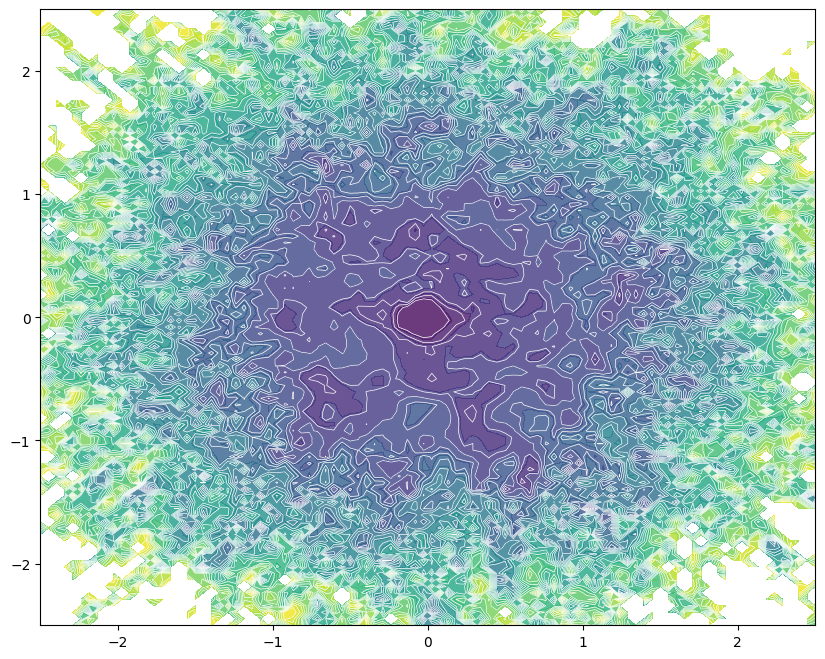

In [15]:
filtered_params = [(name, p) for name, p in model.named_parameters() if p.requires_grad]
layers_name='all'

# layers_name='first_8'
# filtered_params = filtered_params[1:73] #First 8 layers - I like this - facorite so far

# layers_name='last_8'
# filtered_params = filtered_params[73:] #Last 8 layers - some nice structue, but yeah more parabolic than I would like

# num_points=12
# num_samples=5

random_seeds=[[i, i+100] for i in range(num_samples)]

for random_seed_1, random_seed_2 in random_seeds:
    print(random_seed_1, random_seed_2)
    
    # Generate and normalize random directions
    direction1 = get_random_directions(filtered_params, seed=random_seed_1)
    direction2 = get_random_directions(filtered_params, seed=random_seed_2)
    
    direction1 = normalize_direction(direction1, filtered_params)
    direction2 = normalize_direction(direction2, filtered_params)
    
    original_params = OrderedDict()
    for name, param in filtered_params:
        original_params[name] = param.data.clone()
    
    alphas=np.linspace(-2.5, 2.5, num_points)
    betas=np.linspace(-2.5, 2.5, num_points)
    losses=[]
    model.eval()
    with torch.no_grad():
        for i, alpha in enumerate(tqdm(alphas)):
            losses.append([])
            for j, beta in enumerate(betas):
                for name, param in model.named_parameters():
                    if name in direction1:
                        param.data = original_params[name] + alpha * direction1[name] + beta*direction2[name]
                
                outputs = model(input_ids, labels=input_ids)
                my_probs=F.softmax(outputs.logits, dim=-1)
                paris_only_loss=-np.log(my_probs[0, 5, 12366].item())
                losses[-1].append(paris_only_loss)
        
        for name, param in model.named_parameters(): # Restore original parameters
            if name in original_params: 
                param.data.copy_(original_params[name])
    
    losses=np.array(losses)
    
    plt.clf()
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    surface = ax.plot_surface(alphas, betas, losses, cmap='viridis', edgecolor='none', alpha=0.8)
    plt.savefig(save_dir +'/'+prefix+str(random_seed_1)+'_'+str(random_seed_2)+'_'+layers_name+'_3d.png')
    
    plt.clf()
    fig, ax = plt.subplots(figsize=(10, 8))
    contourf = ax.contourf(alphas, betas, losses, 20, cmap='viridis', alpha=0.8)
    contour = ax.contour(alphas, betas, losses, 30, colors='white', linewidths=0.5)
    plt.savefig(save_dir +'/'+prefix+str(random_seed_1)+'_'+str(random_seed_2)+'_'+layers_name+'_2d.png')